In [13]:
from pycfd.reference.atmospheric_flow import stratification_profiles, saturation_calculation
from pyclouds.common import Var
from pyclouds import cloud_equations, plotting

import odespy, numpy as np

%matplotlib inline

In [14]:


ambient_stratification = stratification_profiles.Soong1973Dry()

g = ambient_stratification.g
R_d = ambient_stratification.gas_properties.R()
cp_d = ambient_stratification.gas_properties.cp()

constants = {'R_d': R_d, 'cp_d': cp_d, 'g': g }

In [15]:
z_points = np.linspace(100., 4e3, 500)

w0 = 0.1
dT = 0.2
T0 = ambient_stratification.temp(0.0) + dT

Integration stopped: vertical velocity dropped to zero
RKFehlberg terminated at t=998.798


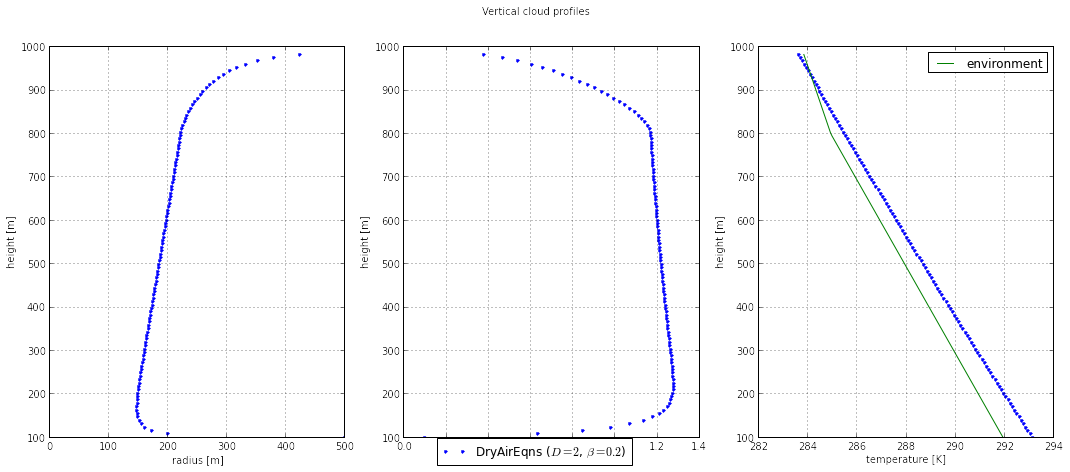

In [16]:
cloud_model = cloud_equations.DryAirOnly(environment=ambient_stratification, constants=constants, D=2.)

initial_condition = Var.make_state(r=500.0, w=w0, T=T0)
p1 = cloud_model.integrate(initial_condition, z_points)
p = p1.plot()

In [17]:
r = p1.F[:,Var.r]
Tc = p1.F[:,Var.T]
w = p1.F[:,Var.w]
z = p1.z

# Continuity equation

In [18]:
inv_f_dfdz = lambda f, z: 1./(.5*(f[1:] + f[:-1]))*(f[1:]-f[:-1])/(z[1:]-z[:-1])

x1 = 2.*inv_f_dfdz(r, z)
x2 = 1.*inv_f_dfdz(w, z)
x3 = -1.0*inv_f_dfdz(Tc, z)
x4 = -g/(R_d*.5*(Tc[1:] + Tc[:-1]))

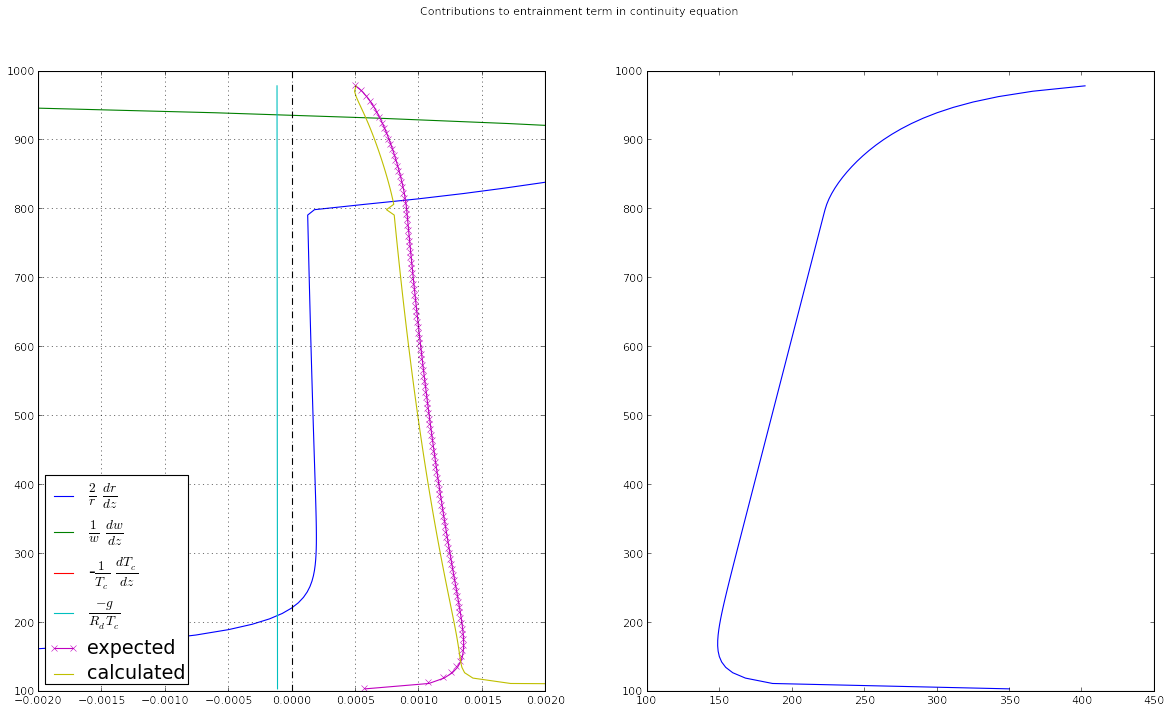

In [33]:
import matplotlib.pyplot as plot
import matplotlib as mpl
mpl.rc("savefig", dpi=80)

inv_f_dfdz__label = lambda v: r"$\frac{1}{%s}\ \frac{d%s}{dz}$" % (v, v)

z_ = 0.5*(z[1:] + z[:-1])
r_ = 0.5*(r[1:] + r[:-1])

plot.figure(figsize=(18,10))
plot.subplot(121)
plot.plot(x1, z_, label=r"$\frac{2}{r}\ \frac{dr}{dz}$")
plot.plot(x2, z_, label=inv_f_dfdz__label('w'))
plot.plot(x3, z_, label="-" + inv_f_dfdz__label('T_c'))
plot.plot(x4, z_, label=r"$\frac{-g}{R_d T_c}$")

mu_model = 0.2/(0.5*(r[1:] + r[:-1]))
plot.plot(mu_model, z_, label='expected', marker='x')
plot.plot(x1 + x2 + x3 + x4, z_, label='calculated')

mu_calculated_cont = x1 + x2 + x3 + x4

plot.grid(True)
plot.legend(loc='lower left')
plot.gca().axvline(x=0, color='k', linestyle='--')
leg = plot.gca().get_legend()
ltext  = leg.get_texts()
plot.setp(ltext, fontsize='xx-large')
plot.xlim(-0.002, 0.002)

plot.subplot(122)
plot.plot(r_, z_)

plot.suptitle('Contributions to entrainment term in continuity equation')

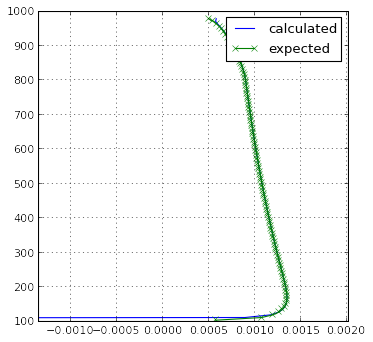

In [20]:
plot.figure(figsize=(5,5))
plot.plot(x1 + x2 + x3 + x4, z_, label='calculated')
mu_model = 0.2/(0.5*(r[1:] + r[:-1]))
plot.plot(mu_model, z_, label='expected', marker='x')
plot.legend()
plot.xlim(-np.max(mu_model), 1.5*np.max(mu_model))
plot.grid(True)

# momentum equation

In [21]:
dfdz = lambda f, z: (f[1:]-f[:-1])/(z[1:]-z[:-1])
center = lambda v: 0.5*(v[1:] + v[:-1])


z_ = center(z)
w_ = center(w)
r_ = center(r)

Te = ambient_stratification.temp(z)
gamma = p1.cloud_model.gamma
D = p1.cloud_model.D

x1 = -1./w_*dfdz(w, z)
x2 = center(g/(1.+gamma)*(Tc-Te)/Te)/w_**2.
x3 = -center(D/r)

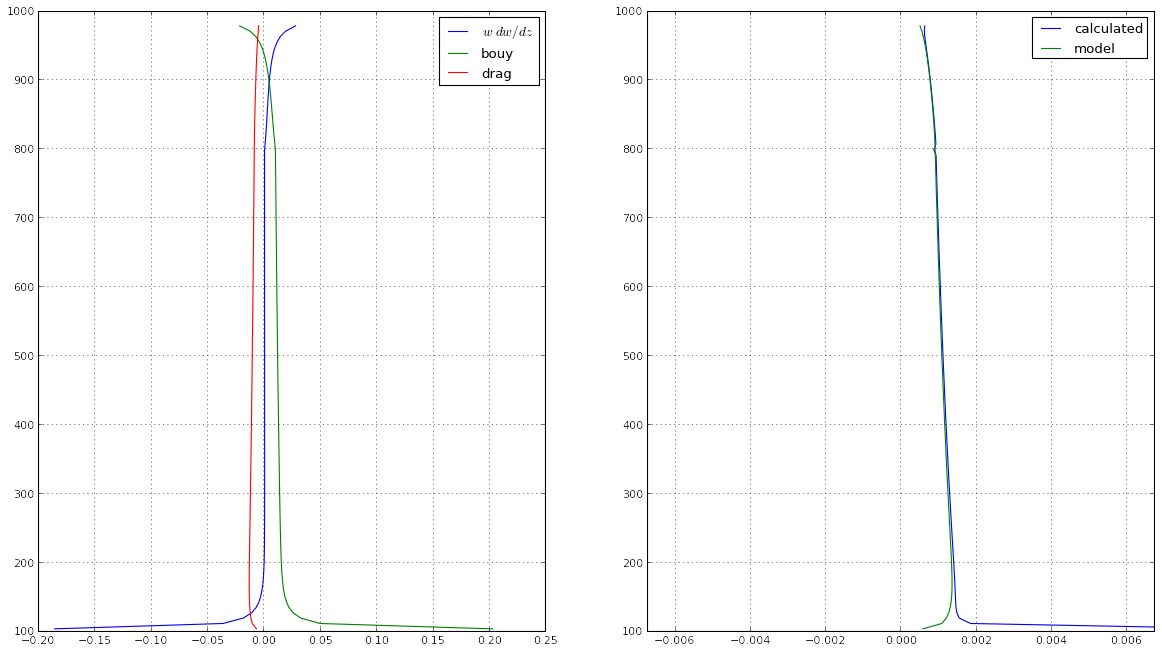

In [31]:
plot.figure(figsize=(18,10))
plot.subplot(121)
plot.plot(x1, z_, label=r'$w\ dw/dz$')
plot.plot(x2, z_, label='bouy')
plot.plot(x3, z_, label='drag')

plot.legend()
plot.grid(True)

mu_calculated = x1 + x2 + x3
mu_model = 0.2/r_

plot.subplot(122)
plot.plot(mu_calculated, z_, label='calculated')
plot.plot(mu_model, z_, label='model')
plot.xlim(-5*np.max(mu_model), 5*np.max(mu_model))
plot.legend()
plot.grid(True)

(0, 0.002)

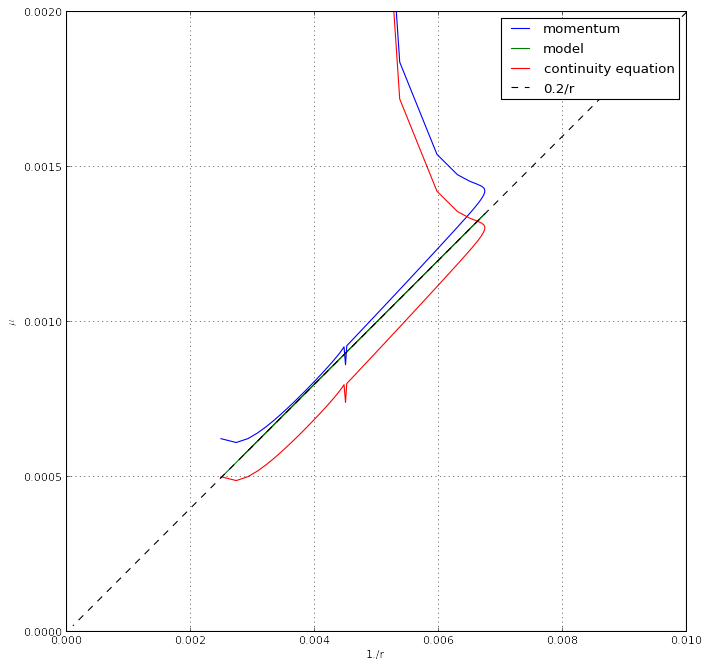

In [57]:
plot.figure(figsize=(10,10))
plot.plot(1./r_, mu_calculated, label='momentum')
plot.plot(1./r_, mu_model, label='model')
plot.plot(1./r_, mu_calculated_cont, label='continuity equation')
r_2 = np.linspace(100., 1.0e4)
plot.plot(1.0/r_2, 0.2/r_2, linestyle='--', color='black', label='0.2/r')
plot.legend()
plot.xlabel('1./r')
plot.ylabel(r'$\mu$')
#plot.xlim(0, 0.004)
plot.grid(True)
plot.ylim(0, 0.002)